# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Data Loading

In [ ]:
# Load Hospital data to view stock sales
hd = pd.read_csv('/content/Hospital_data.csv')

In [ ]:
# Load Drugs data to view stock purchases
dd = pd.read_csv('/content/Drugs_data.csv')

# Exploratory Data Analysis (EDA)

## Total selling stock of each drug in each branch

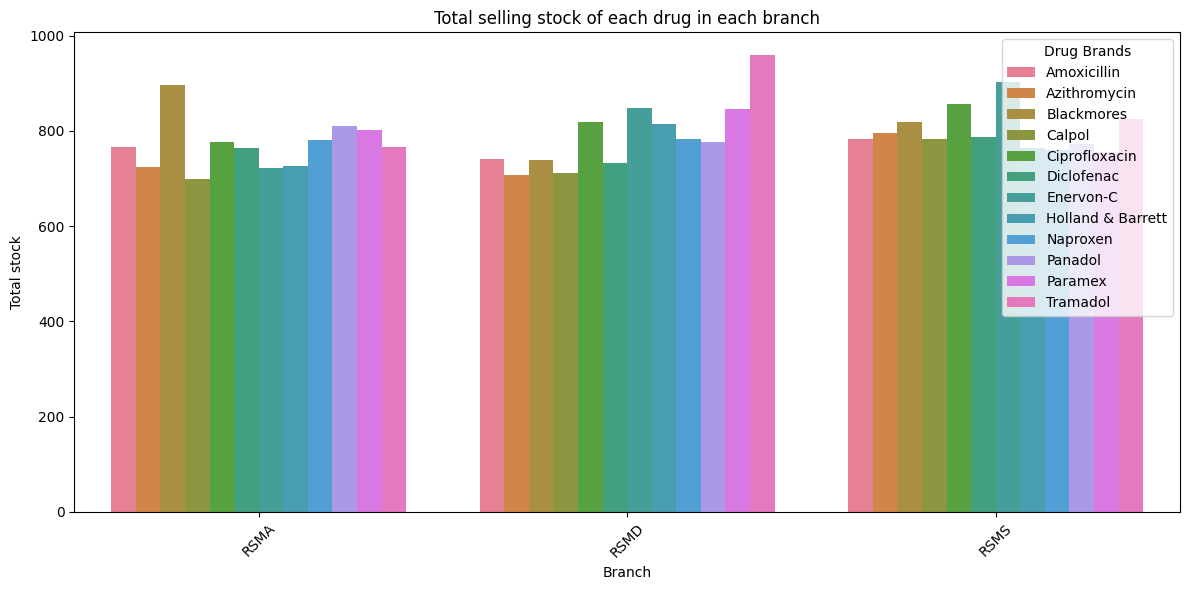

In [ ]:
total_quantity_per_drug_per_branch = hd.groupby(['Branch', 'Drug Brands'])['Drug Qty'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=total_quantity_per_drug_per_branch, x='Branch', y='Drug Qty', hue='Drug Brands')
plt.title('Total selling stock of each drug in each branch')
plt.xlabel('Branch')
plt.ylabel('Total stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Total purchasing stock of each drug in each branch

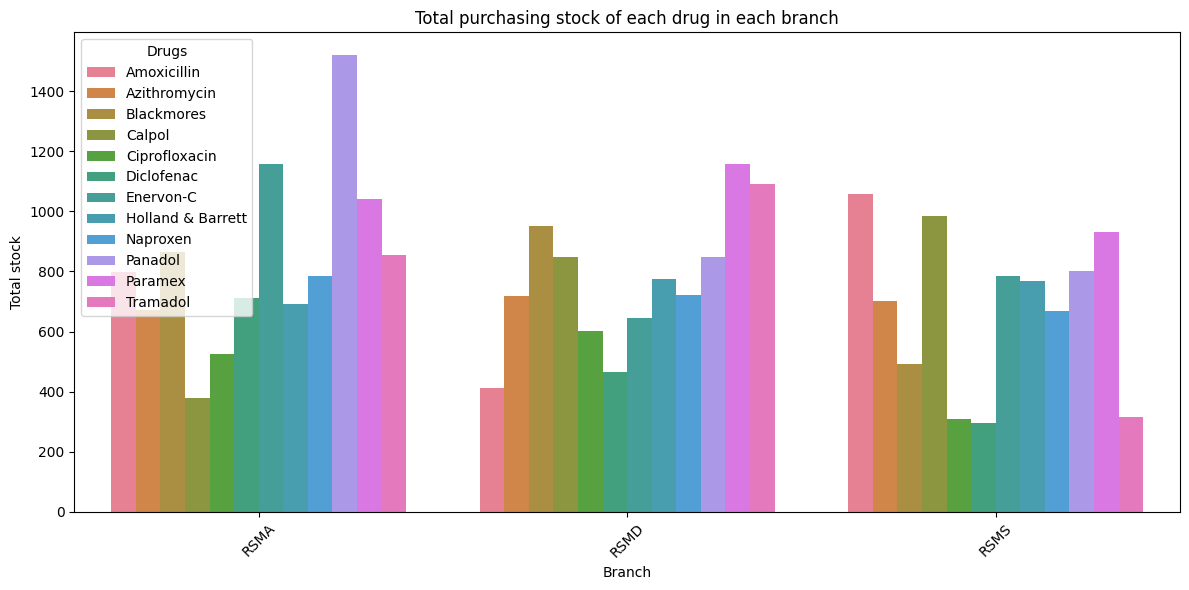

In [ ]:
total_quantity_per_drug_per_branch = dd.groupby(['Branch', 'Drugs'])['Qty'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=total_quantity_per_drug_per_branch, x='Branch', y='Qty', hue='Drugs')
plt.title('Total purchasing stock of each drug in each branch')
plt.xlabel('Branch')
plt.ylabel('Total stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Total selling stock and purchasing stock of drugs over time for each branch

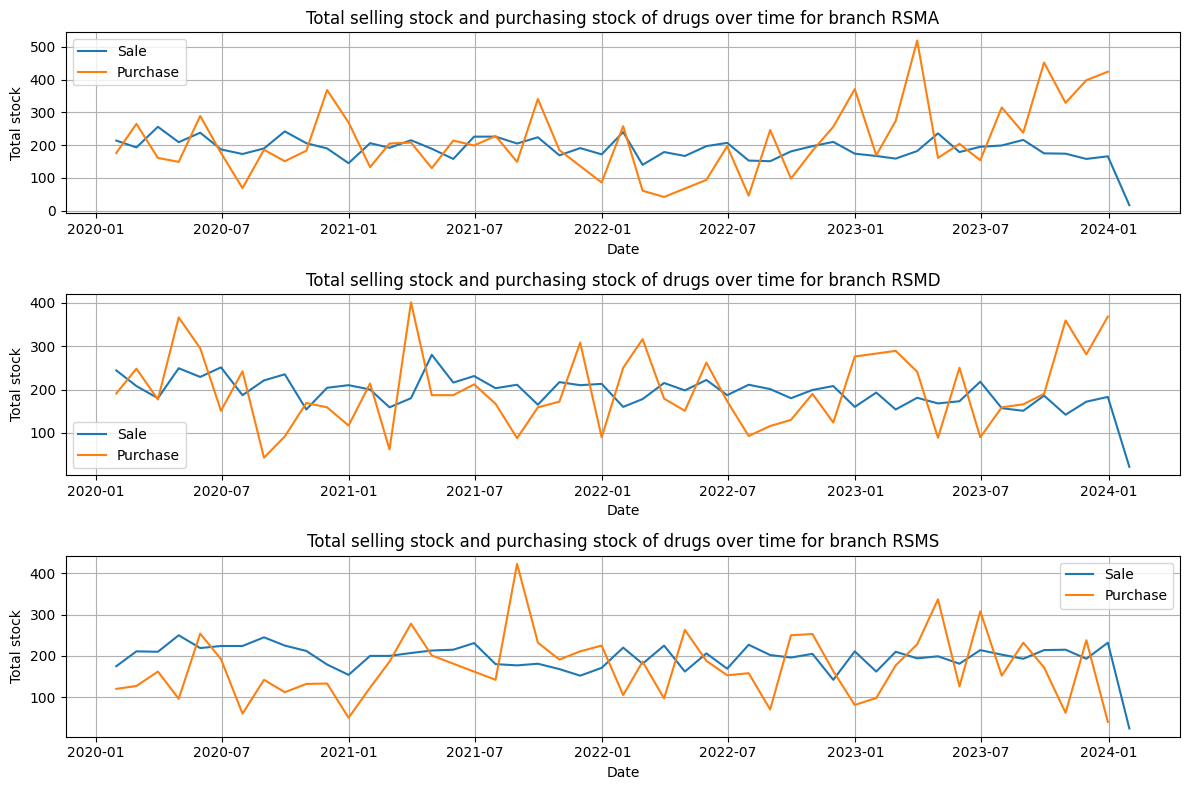

In [ ]:
hd['Date OUT'] = pd.to_datetime(hd['Date OUT'])
dd['Date'] = pd.to_datetime(dd['Date'])
total_quantity_per_branch_over_time_hd = hd.groupby(['Branch', pd.Grouper(key='Date OUT', freq='M')])['Drug Qty'].sum().reset_index()
total_quantity_per_branch_over_time_dd = dd.groupby(['Branch', pd.Grouper(key='Date', freq='M')])['Qty'].sum().reset_index()
branches = total_quantity_per_branch_over_time_hd['Branch'].unique()
plt.figure(figsize=(12, 8))
for idx, branch in enumerate(branches, start=1):
    plt.subplot(len(branches), 1, idx)
    branch_data_hd = total_quantity_per_branch_over_time_hd[total_quantity_per_branch_over_time_hd['Branch'] == branch]
    branch_data_dd = total_quantity_per_branch_over_time_dd[total_quantity_per_branch_over_time_dd['Branch'] == branch]
    plt.plot(branch_data_hd['Date OUT'], branch_data_hd['Drug Qty'], label='Sale')
    plt.plot(branch_data_dd['Date'], branch_data_dd['Qty'], label='Purchase')
    plt.title(f'Total selling stock and purchasing stock of drugs over time for branch {branch}')
    plt.xlabel('Date')
    plt.ylabel('Total stock')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

# Feature Engineering

## Data preprocessing

In [ ]:
# Take the relevant columns from the Hospital Data to be the same as the columns from the Drugs Data
hd1 = hd[['Date OUT', 'Drug Brands', 'Drug Qty', 'Branch']]

In [ ]:
# Adjusted column naming for all tables
hd1.rename(columns={'Date OUT': 'Date', 'Drug Qty': 'OUT Qty'}, inplace=True)
dd.rename(columns={'Drugs': 'Drug Brands', 'Qty': 'IN Qty'}, inplace=True)

<ipython-input-8-f666f161b6b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hd1.rename(columns={'Date OUT': 'Date', 'Drug Qty': 'OUT Qty'}, inplace=True)


In [ ]:
# Combine all tables
mdf = pd.merge(dd, hd1, on=['Date', 'Drug Brands', 'Branch'], how='outer')

In [ ]:
# Handling missing value
mdf.fillna(0, inplace=True)

Missing value handling is done with the number 0 only, this is because some combinations of the Date, Drug Brands, and Branch columns do not have purchase/sales stock data values.

In [ ]:
# Add a column to view the gap value between purchasing stock and selling stock
mdf['Adjusted Qty'] = mdf['IN Qty'] - mdf['OUT Qty']

In [ ]:
# Change the data type in the 'Date' column to datetime and sort from the earliest
mdf['Date'] = pd.to_datetime(mdf['Date'])
data = mdf.sort_values(by='Date')

In [ ]:
# Group the 'Date' column based on month
mmdf = data.groupby([data['Date'].dt.to_period('M'), 'Drug Brands', 'Branch']).agg({'IN Qty': 'sum', 'OUT Qty': 'sum', 'Adjusted Qty': 'sum'}).reset_index()

In [ ]:
# Add new columns based on month and year from the 'Date' column
mmdf['year'] = mmdf.Date.dt.year
mmdf['month'] = mmdf.Date.dt.month

In [ ]:
# Duplicate data to delete the 'Date' column
smmdf = mmdf.copy()
smmdf.drop('Date', axis=1, inplace=True)

Duplicate data is created to facilitate the separation of data into training and testing sets. This division allows us to isolate features for training the model and reserve additional features for evaluating its performance. The reason for this separation is that during model training, certain data transformations, such as converting a datetime column, are applied. Consequently, when evaluating the model, direct comparisons with datetime data become impractical due to the transformations applied during training.

In [ ]:
# Calculate the monthly average quantity of selling stock for each combination of Drug Brands, Branch, and Month
smmdf['monthly_avg'] = smmdf.groupby(['Drug Brands','Branch','month'])['OUT Qty'].transform('mean')

## Encoding

In [ ]:
# Create encoding for categorical columns, which are the 'Drug Brands' and 'Branch' columns
label_encoder_drugs = LabelEncoder()
label_encoder_branch = LabelEncoder()

smmdf['Drug Brands'] = label_encoder_drugs.fit_transform(smmdf['Drug Brands'])
smmdf['Branch'] = label_encoder_branch.fit_transform(smmdf['Branch'])

## Scaling

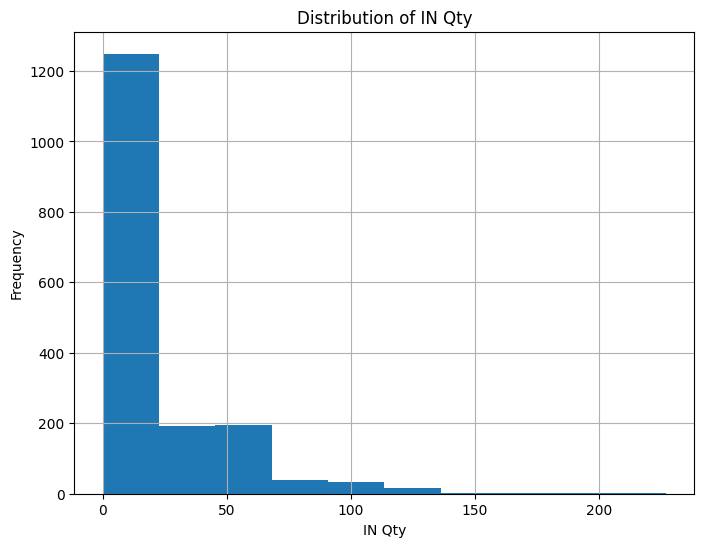

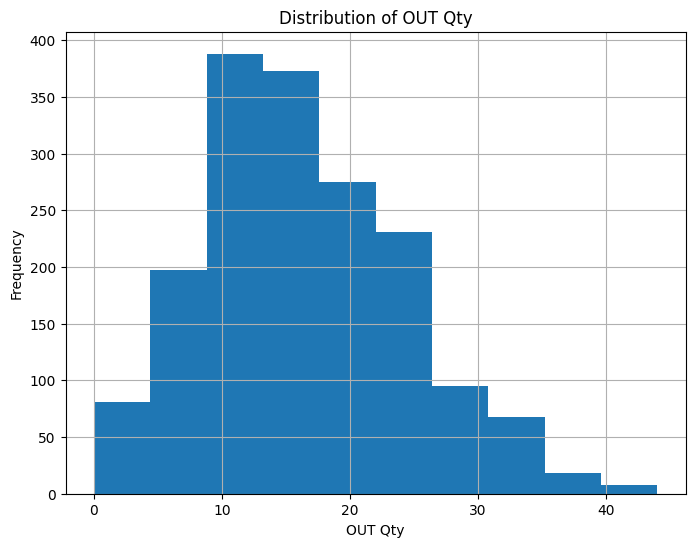

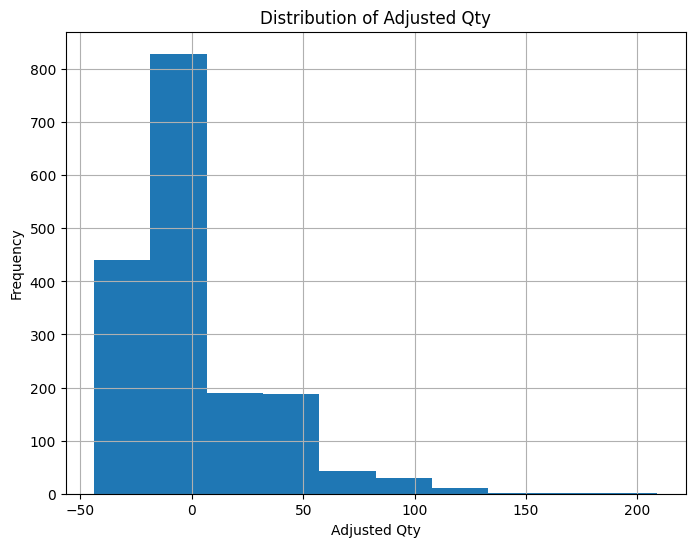

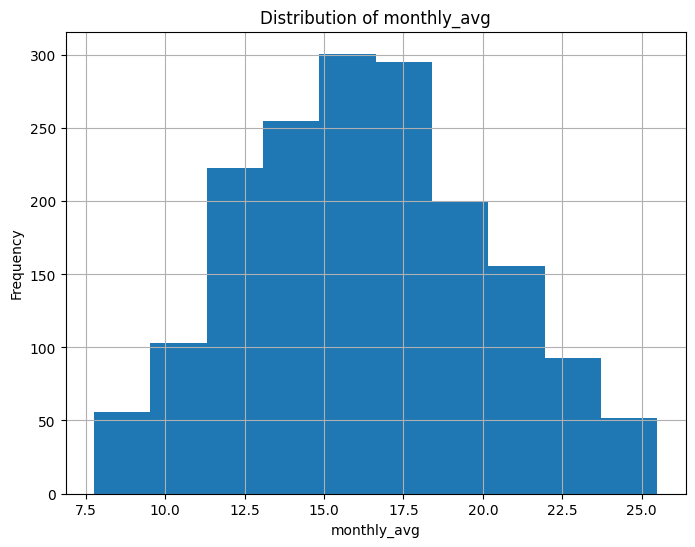

In [ ]:
# Visualize the distribution of data in each numerical column
columns_to_exclude = ['Drug Brands', 'Branch', 'year', 'month']

for column in smmdf.columns:
    if column not in columns_to_exclude and smmdf[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(8, 6))
        smmdf[column].hist()
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()

Scaling is not done because the data values are not large.

## Feature Selection

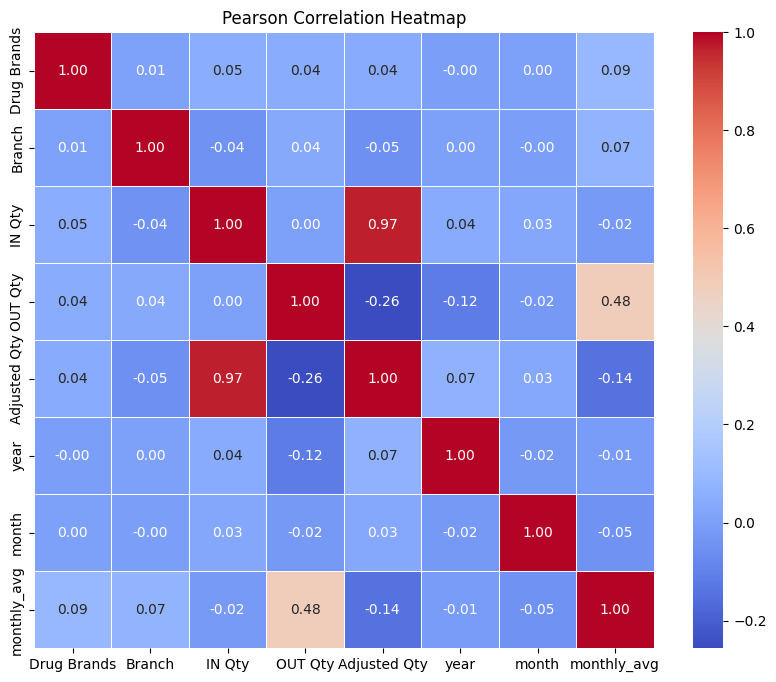

In [ ]:
# Visualize correlation between columns
df_encoded = pd.get_dummies(smmdf)
corr = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

In [ ]:
# Check for multicollinearity across columns
def calc_vif(nilai):
    vif = pd.DataFrame()
    vif["variables"] = nilai.columns
    vif["VIF"] = [variance_inflation_factor(nilai.values, i) for i in range(nilai.shape[1])]
    vif = vif.sort_values(by=['VIF'],ascending=False)
    return(vif)

calc_vif(smmdf)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,variables,VIF
2,IN Qty,inf
3,OUT Qty,inf
4,Adjusted Qty,inf
5,year,26.229161
7,monthly_avg,25.707747
6,month,4.471970
0,Drug Brands,3.579131
1,Branch,2.514886


**Note** : VIF (Variance Inflation Factor) is used in regression analysis to evaluate multicollinearity, which is when two or more independent variables in a regression model have a strong relationship with each other.

In [ ]:
# Delete irrelevant columns
for df in [smmdf]:
    df.drop(['IN Qty',
             'year'],
              axis=1,
              inplace=True)

Based on the correlation value and VIF value, the columns that are not used are column IN Qty and column year because they have a correlation value that is close to 0 and have a VIF value that can be said to be high.

## Data Splitting

In [ ]:
# Train Test Split for additional features evaluating its performance
X_traint, X_testt, y_traint, y_testt = train_test_split(mmdf.drop('OUT Qty',axis=1),mmdf.pop('OUT Qty'), random_state=123, test_size=0.2)
X_testt['Date'] = X_testt['Date'].dt.to_timestamp().dt.to_period('M').astype(str)

In [ ]:
# Train Test Split for training the model
X_train, X_test, y_train, y_test = train_test_split(smmdf.drop('OUT Qty',axis=1),smmdf.pop('OUT Qty'), random_state=123, test_size=0.2)
X_traino = X_train.apply(pd.to_numeric, errors='coerce')
X_testo = X_test.apply(pd.to_numeric, errors='coerce')
y_traino = y_train.apply(pd.to_numeric, errors='coerce')
y_testo = y_test.apply(pd.to_numeric, errors='coerce')

# Model Training

Initialize and train four different regression models:

In [ ]:
# Linear Regression Model
model_lr = LinearRegression()
model_lr.fit(X_traino, y_traino)

LinearRegression()

In [ ]:
# Random Forest Regressor Model
model_rfr = RandomForestRegressor()
model_rfr.fit(X_traino, y_traino)

RandomForestRegressor()

In [ ]:
# Support Vector Regressor Model
model_svr = SVR()
model_svr.fit(X_traino, y_traino)

SVR()

In [ ]:
# XGBoost Regressor Model
model_xgb = XGBRegressor()
model_xgb.fit(X_traino, y_traino)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Model Evaluation

In [ ]:
# Check the cross val values for all models
models = {
    'Linear Regression': model_lr,
    'Random Forest Regressor': model_rfr,
    'SVR': model_svr,
    'XGBRegressor': model_xgb
}

datacv = {'Model': [], 'Mean Score': [], 'Std Score': []}

for name, model in models.items():
    scores = cross_val_score(model, X_traino, y_traino, cv=10)
    datacv['Model'].append(name)
    datacv['Mean Score'].append(scores.mean())
    datacv['Std Score'].append(scores.std())

pd.DataFrame(datacv)

,Model,Mean Score,Std Score
0,Linear Regression,0.236381,0.063976
1,Random Forest Regressor,0.698302,0.096544
2,SVR,0.602801,0.104527
3,XGBRegressor,0.636141,0.129198


In [ ]:
# Check the metric evaluation values for all models
results = []

def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_metrics = {}
    test_metrics = {}

    y_train_pred = model.predict(X_train)
    train_metrics['MAE'] = mean_absolute_error(y_train, y_train_pred)
    train_metrics['RMSE'] = mean_squared_error(y_train, y_train_pred, squared=False)
    train_metrics['R2-Score'] = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    test_metrics['MAE'] = mean_absolute_error(y_test, y_test_pred)
    test_metrics['RMSE'] = mean_squared_error(y_test, y_test_pred, squared=False)
    test_metrics['R2-Score'] = r2_score(y_test, y_test_pred)

    return train_metrics, test_metrics

for name, model in models.items():
    train_metrics, test_metrics = evaluate_model(model, X_traino, y_traino, X_testo, y_testo)
    results.append({
        'Model': name,
        'Train MAE': train_metrics['MAE'],
        'Train RMSE': train_metrics['RMSE'],
        'Train R2-Score': train_metrics['R2-Score'],
        'Test MAE': test_metrics['MAE'],
        'Test RMSE': test_metrics['RMSE'],
        'Test R2-Score': test_metrics['R2-Score']
    })

pd.DataFrame(results)

,Model,Train MAE,Train RMSE,Train R2-Score,Test MAE,Test RMSE,Test R2-Score
0,Linear Regression,5.405825,6.774449,0.253698,5.049443,6.433510,0.334894
1,Random Forest Regressor,0.651228,1.593329,0.958716,1.768504,4.008307,0.741823
2,SVR,2.264850,4.850034,0.617478,2.287509,4.598663,0.660173
3,XGBRegressor,0.141300,0.317165,0.998364,2.138281,4.544230,0.668170


From the Cross Val results and Evaluation Metrics, the Random Forest Regressor (RFR) model was chosen because it has a high Mean Score value, a low Std Score value, a low MAE/RMSE value, a high R2-Score value, and a fairly low gap in the prediction value between train and test.

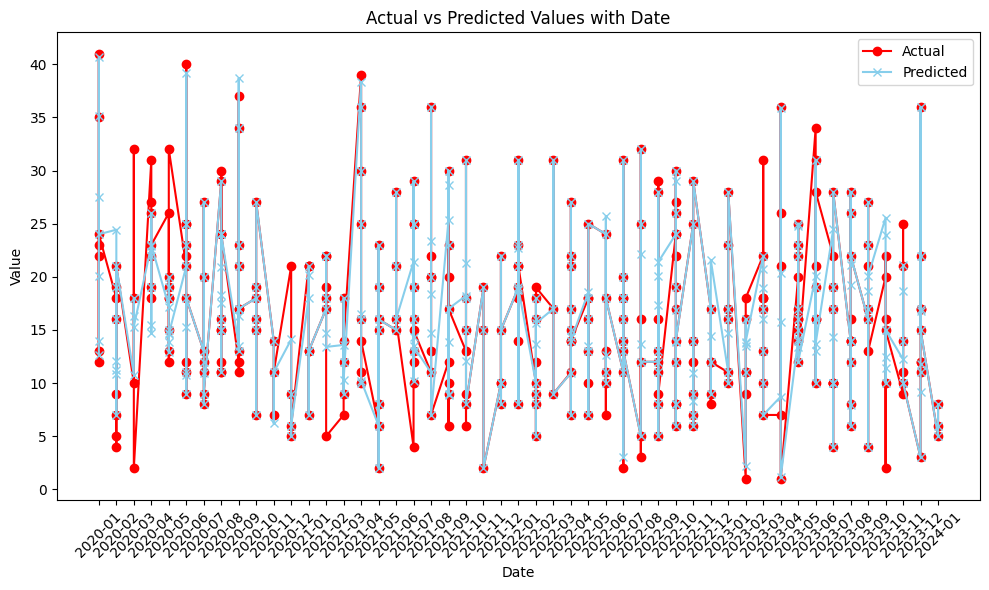

In [ ]:
# Displays a graph of the comparison results between the actual value and the predicted value
results = pd.DataFrame({'Date': X_testt['Date'], 'Actual': y_testo, 'Predicted': model_rfr.predict(X_testo)})
results.sort_values(by='Date', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(results['Date'], results['Actual'], label='Actual', marker='o', color='red')
plt.plot(results['Date'], results['Predicted'], label='Predicted', marker='x', color='skyblue')
plt.title('Actual vs Predicted Values with Date')
plt.xlabel('Date')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Model Tuning

Tuning is carried out in the hope of improving model performance

In [ ]:
# Perform hyperparameter tuning
param_grid = {
    'n_estimators': [i for i in range(100, 500, 100)],
    'max_depth': [i for i in range(10, 50, 10)],
    'min_samples_split': [i for i in range(10, 50, 10)],
    'min_samples_leaf': [i for i in range(1, 10, 2)]
}

grid_search = GridSearchCV(estimator=model_rfr, param_grid=param_grid,
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_traino, y_traino)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_rfr = grid_search.best_estimator_

Best Parameters: {'max_depth': 40, 'min_samples_leaf': 3, 'min_samples_split': 40, 'n_estimators': 100}


In [ ]:
# Check the comparison of metric evaluation values between before and after model tuning
metrics = {
    "Train Non Tuning": {
        "MAE": mean_absolute_error(y_traino, model_rfr.predict(X_traino)),
        "RMSE": mean_squared_error(y_traino, model_rfr.predict(X_traino), squared=False),
        "R2-Score": r2_score(y_traino, model_rfr.predict(X_traino))
    },
    "Train Tuning": {
        "MAE": mean_absolute_error(y_traino, best_rfr.predict(X_traino)),
        "RMSE": mean_squared_error(y_traino, best_rfr.predict(X_traino), squared=False),
        "R2-Score": r2_score(y_traino, best_rfr.predict(X_traino))
    },
    "Test Non Tuning": {
        "MAE": mean_absolute_error(y_testo, model_rfr.predict(X_testo)),
        "RMSE": mean_squared_error(y_testo, model_rfr.predict(X_testo), squared=False),
        "R2-Score": r2_score(y_testo, model_rfr.predict(X_testo))
    },
    "Test Tuning": {
        "MAE": mean_absolute_error(y_testo, best_rfr.predict(X_testo)),
        "RMSE": mean_squared_error(y_testo, best_rfr.predict(X_testo), squared=False),
        "R2-Score": r2_score(y_testo, best_rfr.predict(X_testo))
    }
}

t_results = pd.DataFrame(metrics)
t_results

,Train Non Tuning,Train Tuning,Test Non Tuning,Test Tuning
MAE,0.651228,1.586724,1.768504,1.777221
RMSE,1.593329,3.466933,4.008307,3.686037
R2-Score,0.958716,0.804540,0.741823,0.781669


After tuning the model, we observed that the evaluation metric for the training data worsened initially. However, notably, the disparity between the predictions on the training and testing data significantly diminished. This indicates that the initial Random Forest Regressor (RFR) model was overfit, but tuning it led to a better fit.

Because of this observation, we chose the tuned Random Forest Regressor (RFR) model for implementation.

# Model Saving

In [ ]:
joblib.dump(label_encoder_drugs, 'led.pkl')
joblib.dump(label_encoder_branch, 'leb.pkl')
joblib.dump(best_rfr, 'rfr.pkl')

['rfr.pkl']